# Simulation of Sequences

In [1]:
import numpy as np
import qutip
import matplotlib.pyplot as plt

import pulser
from pulser_simulation import QutipEmulator

To illustrate the simulation of sequences, let us study a simple one-dimensional system with periodic boundary conditions (a ring of atoms):

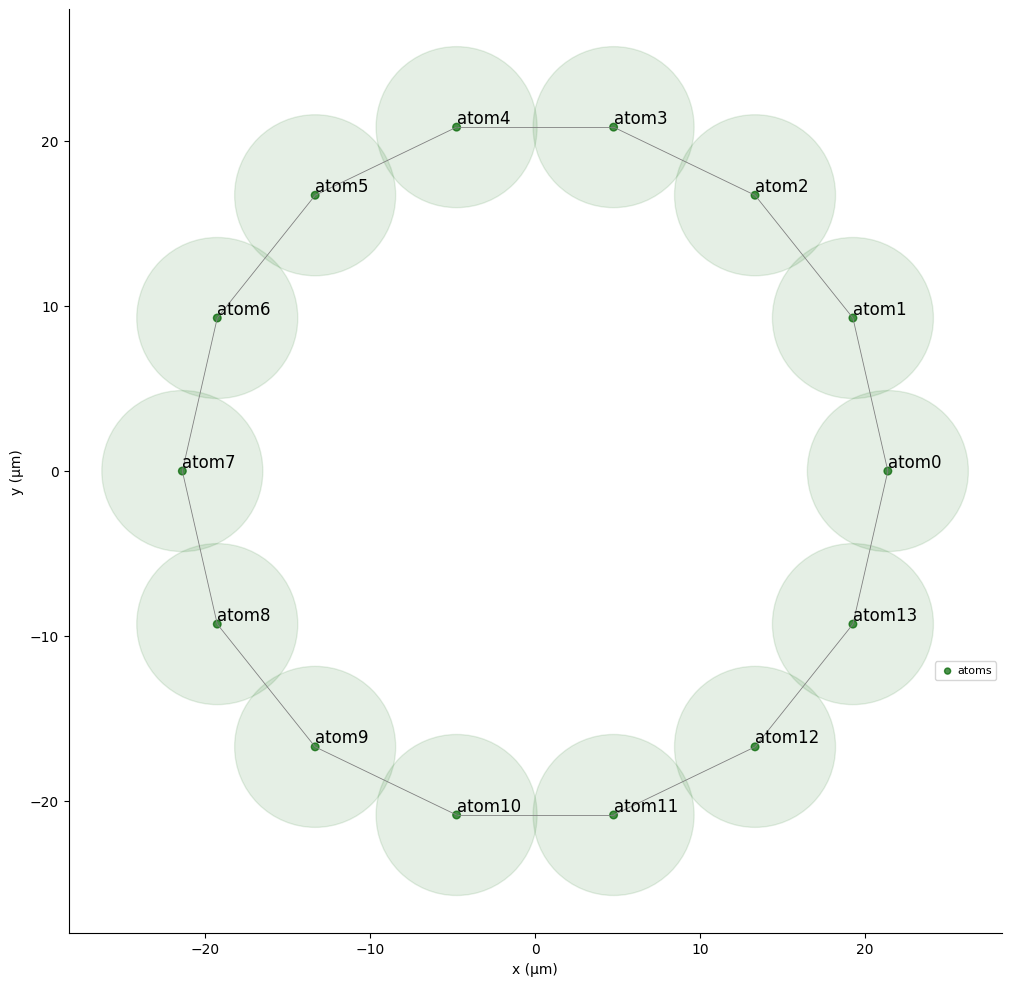

In [2]:
# Setup
L = 14

Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3

delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000

# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = pulser.MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.tan(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

reg = pulser.Register.from_coordinates(coords, prefix="atom")

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

We use the drawing capabilites of the `Register` class to highlight the area **half** the blockade radius away from each atom, which makes it so that overlapping circles correspond to interacting atoms. This is further fleshed out by the graph edges drawn using the `draw_graph` option.

In this register, we shall act with the following pulser sequence, which is designed to reach a state with *antiferromagnetic order*:

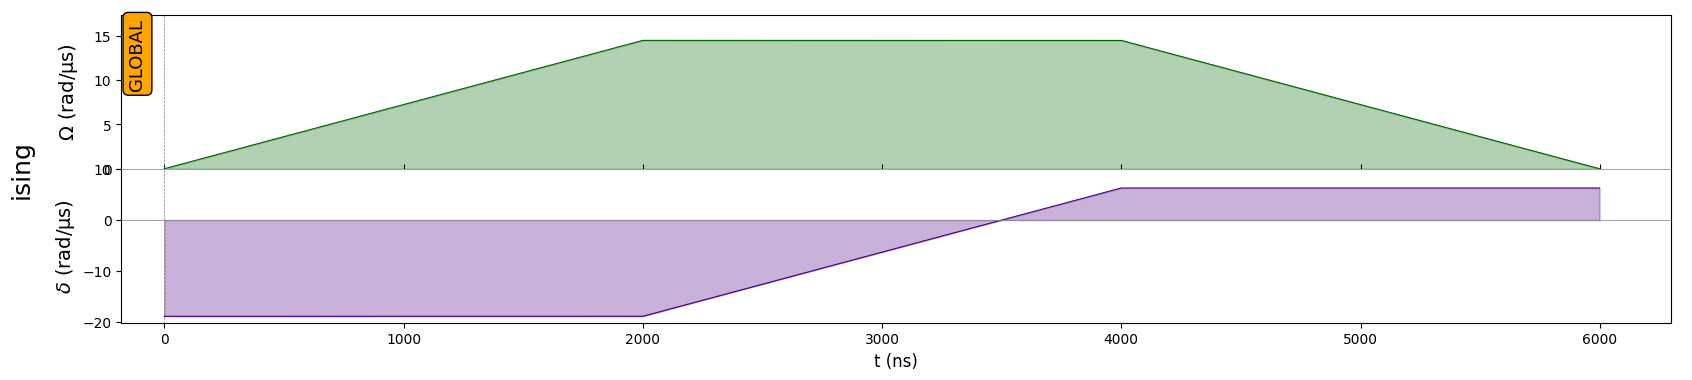

In [3]:
rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = pulser.Sequence(reg, pulser.MockDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

seq.draw()

## 1. Running a Simulation

First we define our `QutipEmulator` object, which creates an internal respresentation of the quantum system, including the Hamiltonian which will drive the evolution:

In [4]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)

Notice we have included the parameter `sampling_rate` which allows us to determine how many samples from the pulse sequence we wish to simulate. In the case of the simple shapes in our sequence, only a very small fraction is needed. This largely accelerates the simulation time in the solver.

To run the simulation we simply apply the method `run()`. At the time of writing of this notebook, the method uses a series of routines from **QuTiP** for solving the Schröedinger equation of the system. It returns a `SimulationResults` object, which will allow the study or post-processing of the states for each time step in our simulation. Additionally, we can include a progress bar to have an estimate of how the simulation is advancing:

In [5]:
results = sim.run(progress_bar=True)

10.0%. Run time:   0.78s. Est. time left: 00:00:00:07
20.0%. Run time:   1.61s. Est. time left: 00:00:00:06
30.0%. Run time:   2.58s. Est. time left: 00:00:00:06
40.0%. Run time:   3.64s. Est. time left: 00:00:00:05
50.0%. Run time:   4.83s. Est. time left: 00:00:00:04
60.0%. Run time:   6.18s. Est. time left: 00:00:00:04
70.0%. Run time:   7.72s. Est. time left: 00:00:00:03
80.0%. Run time:   9.13s. Est. time left: 00:00:00:02
90.0%. Run time:  10.41s. Est. time left: 00:00:00:01
Total run time:  11.58s


## 2. Using the `SimulationResults` object

The `SimulationResults` object that we created contains the quantum state at each time step. We can call them using the `states` attribute:

In [6]:
results.states[23]  # Given as a `qutip.Qobj` object

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-7.766121491257674e-20+3.431076155486485e-20j)
  (1, 0)	(2.058156969364152e-18-1.2955679428739214e-18j)
  (2, 0)	(2.0581569693641486e-18-1.295567942873919e-18j)
  (3, 0)	(-4.103588325586898e-17+3.84122527660353e-17j)
  (4, 0)	(2.0581569693641516e-18-1.295567942873933e-18j)
  (5, 0)	(-5.425399373385e-17+4.5410400438290795e-17j)
  (6, 0)	(-4.1035883255868886e-17+3.8412252766035445e-17j)
  (7, 0)	(7.58503087954551e-16-1.0477973618149083e-15j)
  (8, 0)	(2.0581569693641555e-18-1.2955679428739374e-18j)
  (9, 0)	(-5.2708025252890147e-17+4.533872811408899e-17j)
  (10, 0)	(-5.4253993733850097e-17+4.541040043829092e-17j)
  (11, 0)	(1.0326109519654464e-15-1.2676914581403953e-15j)
  (12, 0)	(-4.1035883255868886e-17+3.8412252766035587e-17j)
  (13, 0)	(1.0326109519654446e-15-1.2676914581403938e-15j)
  (14, 0)	(7.585030879545472e-16-1.04

We can sample the final state directly, using the `sample_final_state()` method from the `SimulationResults` object. We try it with $1000$ samples and discard the less frequent bitstrings:

<BarContainer object of 27 artists>

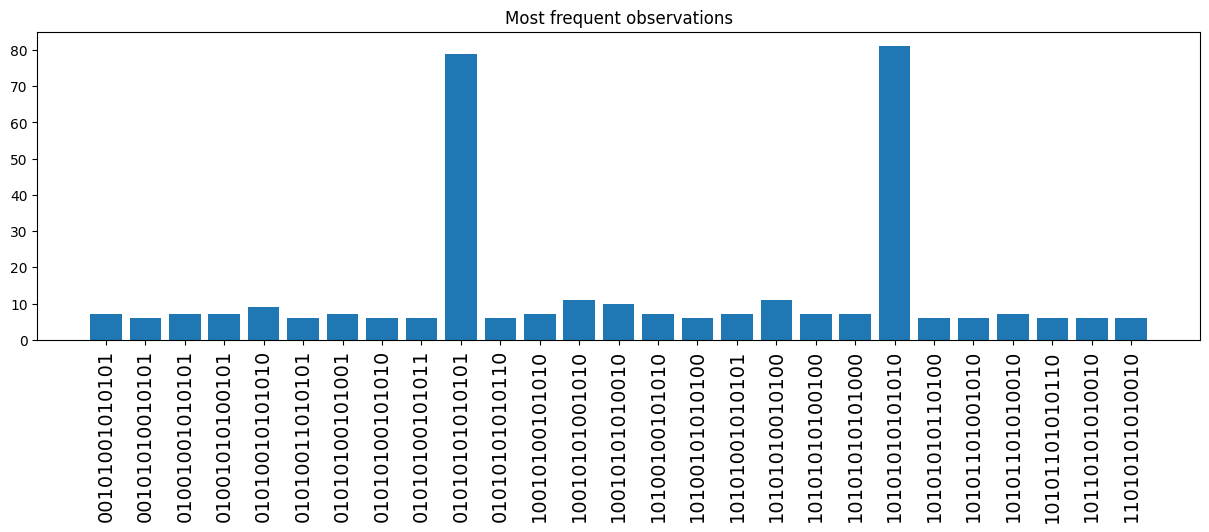

In [7]:
counts = results.sample_final_state(N_samples=1000)

large_counts = {k: v for k, v in counts.items() if v > 5}

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic order states.

We can also compute the expectation values of operators for the states in the evolution, using the `expect()` method, which takes a list of operators (in this case, the local magnetization acting on the $j$-th spin):

In [8]:
def magnetization(j, total_sites):
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)


magn_list = [magnetization(j, L) for j in range(L)]

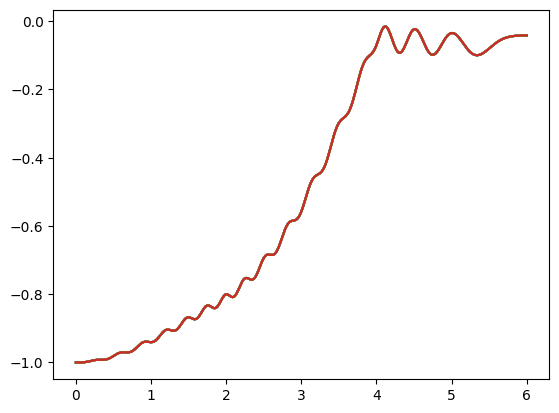

In [9]:
expect_magnetization = results.expect(magn_list)
for data in expect_magnetization:
    plt.plot(sim.evaluation_times, data)

Notice how the local magnetization on *each* atom goes in the same way from $-1$ (which corresponds to the ground state) to $0$. This is expected since as we saw above, the state after the evolution has antiferromagnetic-order, so at each site, there is a compensation of magnetization. The parity (even) and the boundary conditions (periodic) allow for two lowest-energy states, whose superposition is similar to that of the perfectly antiferromagnetic state:  $\Big(|grgr\cdots \rangle + |rgrg\cdots \rangle\Big)/\sqrt{2}$